In [1]:
### Look at possibly mesotidal (between 2-4 m tidal ranges) off the coast of South Carolina. 
# 2023 SD-1045 spent a few months onshore of 50 m isobath off the coast of SC. 
# This could be a good case to show for the need to remove tidal currents from SD ADCP data
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pyfes ### has to use newpycode
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)

In [8]:
### SD-1042 merged nc file info
year = '2023'
platf_num = '1045'
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'

### load adcp data
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_adcp.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
lon = ds_adcp.variables['longitude'][:]
lat = ds_adcp.variables['latitude'][:]
uCur_SD = ds_adcp.variables['vel_east'][:]*100 # cm/s
vCur_SD = ds_adcp.variables['vel_north'][:]*100
# error_vel = ds_adcp.variables['error_vel'][:]*100
# vel_up = ds_adcp.variables['vel_up'][:]*100
percent_good_4_beam = ds_adcp.variables['percent_good_4_beam'][:]
correlation = ds_adcp.variables['correlation'][:]
echo_intensity = ds_adcp.variables['echo_intensity'][:]
depths_cur_SD = ds_adcp.variables['depth'][:] # the shallowest depth should be ~6m. 
depths_cur_SD = depths_cur_SD+1.8
print('Depths of SD:',depths_cur_SD)
print(echo_intensity.shape)

Depths of SD: [  6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.
  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.
  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.
  90.  92.  94.  96.  98. 100. 102. 104.]
(28325, 4, 50)


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_17302/1801692671.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  time = ds_adcp.variables['time'][:]
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_17302/1801692671.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = ds_adcp.variables['longitude'][:]
/var/folders/kq/v

In [3]:
### Use pyfes tool box to build the tide model
path_aviso = os.path.expanduser('~/Documents/Data/AVISO/auxiliary/tide_model/fes2014/')
ConfigFileU = path_aviso+'eastward_velocity.ini'
ConfigFileV = path_aviso+'/northward_velocity.ini'
eastward_velocity = pyfes.Handler("ocean","memory",ConfigFileU)
northward_velocity = pyfes.Handler("ocean", "memory",ConfigFileV)

In [4]:
### get tidal currents by specifying time and locations
u_tide = np.nan*np.ones( len(dtime_cur_SD) )
v_tide = u_tide.copy()
for i in range( len(dtime_cur_SD) ):
    u_tide[i], _, _ = eastward_velocity.calculate(np.array([lon[i]]),np.array([lat[i]]),np.array([dtime_cur_SD[i]]))
    v_tide[i], _, _ = northward_velocity.calculate(np.array([lon[i]]),np.array([lat[i]]),np.array([dtime_cur_SD[i]]))

### de-tide
uCur_SD_detide = np.nan*np.ones( uCur_SD.shape )
vCur_SD_detide = uCur_SD_detide.copy()
for z in range( len(depths_cur_SD) ):
    uCur_SD_detide[:,z] = uCur_SD[:,z] - u_tide
    vCur_SD_detide[:,z] = vCur_SD[:,z] - v_tide

<Figure size 432x288 with 0 Axes>

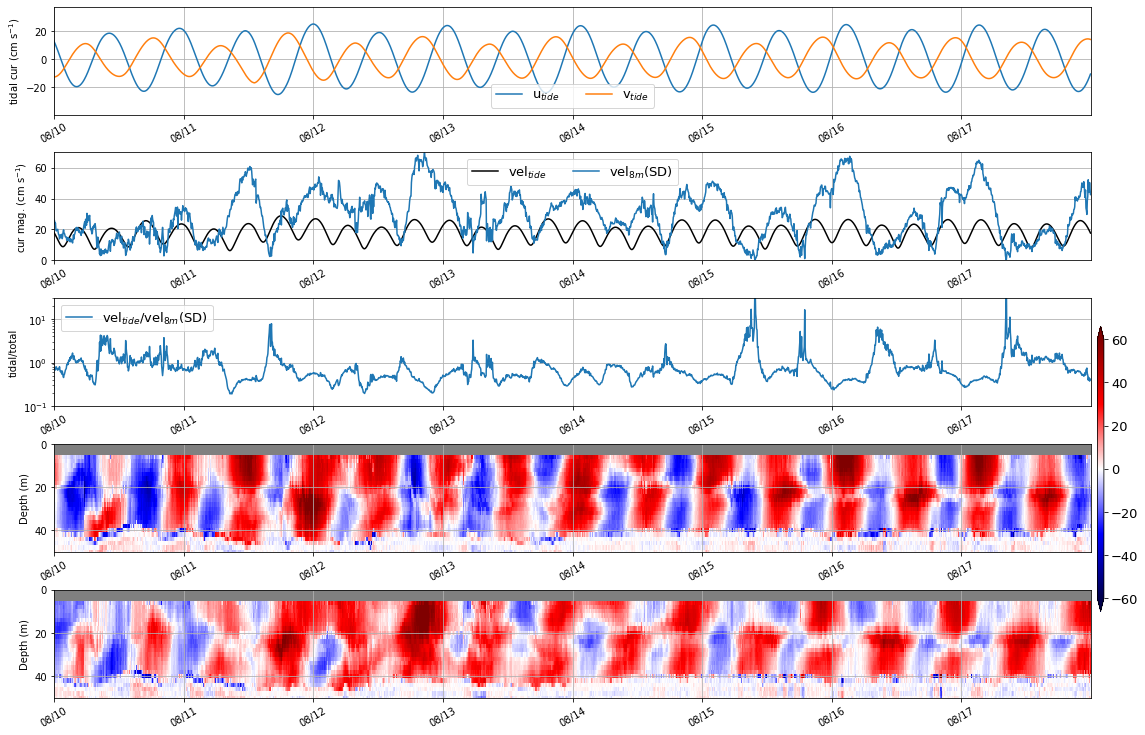

In [5]:
### plot tidal current 
# tlim_plot = [datetime.datetime(int(year),7,15), datetime.datetime(int(year),11,3)]
tlim_plot = [datetime.datetime(int(year),8,10), datetime.datetime(int(year),8,18)]
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
it = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD< tlim_plot[1]) )[0]
iz_SD = 1; z_SD = '{:.0f}m'.format(depths_cur_SD[iz_SD])
nrow = 5
ylabels = ['tidal cur (cm s$^{-1}$)','cur mag. (cm s$^{-1}$)','tidal/total','Depth (m)','Depth (m)']
vellim = [-60,60]
cmap = 'seismic'#'PiYG_r'
###
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 12)
plt.rcParams.update({'font.size': 13})
### u_tidal, v_tidal
plt.subplot(nrow,1,1)
plt.plot( dtime_cur_SD, u_tide, label='u$_{tide}$' )
plt.plot( dtime_cur_SD, v_tide, label='v$_{tide}$' )
### tidal current magnitude
plt.subplot(nrow,1,2)
vel_tide_mag = np.sqrt( np.square(u_tide) + np.square(v_tide) )
plt.plot( dtime_cur_SD, vel_tide_mag, label='vel$_{tide}$',color='k' )
vel_SD_mag = np.sqrt( np.square(uCur_SD) + np.square(vCur_SD) )
plt.plot( dtime_cur_SD, vel_SD_mag[:,iz_SD], label='vel$_{'+z_SD+'}$(SD)')
### ratio of tidal current magnitude / total current magnitude
plt.subplot(nrow,1,3)
plt.semilogy( dtime_cur_SD, np.divide(vel_tide_mag,vel_SD_mag[:,iz_SD]),label='vel$_{tide}$/vel$_{'+z_SD+'}$(SD)' )
### u-SD
plt.subplot(nrow,1,4)
cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, uCur_SD.transpose(),label='u',cmap=cmap,vmin=vellim[0],vmax=vellim[1])
cbar_ax = fig.add_axes([.905,.2,.005,.33])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
### v-SD
plt.subplot(nrow,1,5)
cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, vCur_SD.transpose(),label='u',cmap=cmap,vmin=vellim[0],vmax=vellim[1])
### figure settings
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    if i < 3:
        plt.legend(loc='best',ncol=2)
    if i == 1:
        plt.ylim([0,70])
    if i == 2:
        plt.ylim([1e-1,3e1])
    if i > 2:
        plt.ylim([0,50])
        plt.gca().invert_yaxis()
        plt.gca().set_facecolor('gray')
    plt.grid()
    plt.ylabel(ylabels[i])
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
### save to figure
# plt.savefig('timeseries_uv-tidal_vs_total_SD'+platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_'+\
#             tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

In [11]:
print(echo_intensity.shape, percent_good_4_beam.shape, correlation.shape)

(28325, 4, 50) (28325, 50) (28325, 4, 50)


<Figure size 432x288 with 0 Axes>

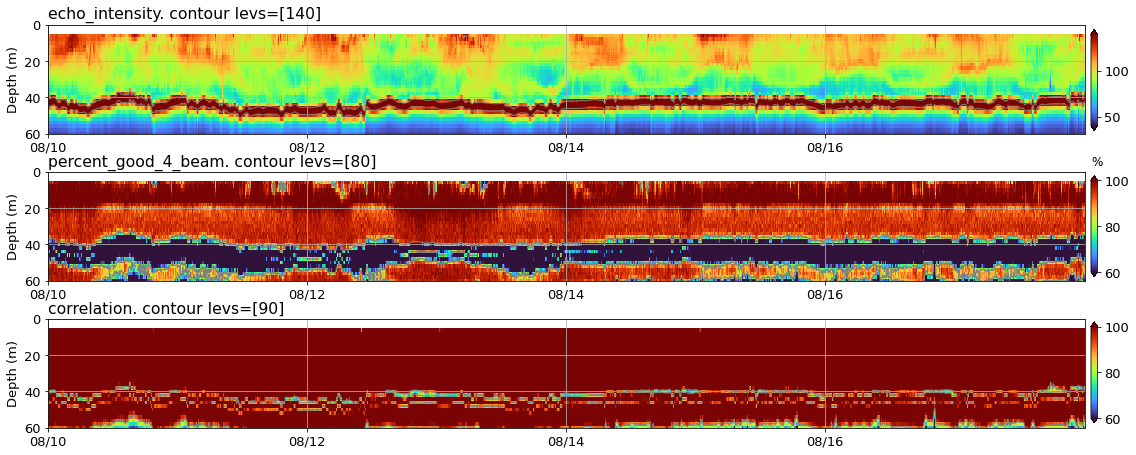

In [13]:
### plot errror velocity & upward velocity
vars_str = ['echo_intensity','percent_good_4_beam','correlation']
vars_unit_str = ['','%',''] 
vellim = [[40,140],[60,100],[60,100]]
cmap = 'turbo'
lev_plot = [[140],[80],[90]]
y0_cb = [0.69,0.4,0.11]
nrow = len(vars_str)
###
plt.clf()
fig, ax = plt.subplots(nrows=nrow)
plt.gcf().set_size_inches(18, 7)
plt.rcParams.update({'font.size': 13})
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    if i == 1:
        var_plot = np.abs(eval(vars_str[i]))
    else:
        var_plot = np.squeeze(eval(vars_str[i])[:,0,:])
    cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, var_plot.transpose(),\
                        label=vars_str[i],cmap=cmap,vmin=vellim[i][0],vmax=vellim[i][1])
    plt.contour(dtime_cur_SD, depths_cur_SD, var_plot.transpose(),linewidths=[1],colors=['gray'],levels=lev_plot[i])    
    ### figure setting
    plt.xticks(tticks[::2],rotation=0)
    plt.gca().set_xticklabels(tticks_label[::2])
    plt.xlim(tlim_plot)
    plt.ylim([0,60])
    plt.gca().invert_yaxis()
    plt.grid()
    plt.ylabel('Depth (m)')
    plt.title(vars_str[i]+'. contour levs='+str(lev_plot[i]),loc='left')
    ### add colorbar
    cbar_ax = fig.add_axes([.905,y0_cb[i],.005,.2])
    axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
    cbar_ax.set_title(vars_unit_str[i],y=1.1,loc='left',fontsize=12)
###
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)


In [40]:
### QC: use d(echo_intensity)/dz. echo intensity, percent_good_4_beam, correlation to flag data
iOK_QC = np.ones( uCur_SD.shape, dtype='bool')
iOK_QC[:,:] = True
# 0: PASS, 1: bottom, 2: weak echo, 3: strong echo, 4: low cpercent good 4 beam, 5: low correlation
iflag = np.zeros(uCur_SD.shape, dtype=int) 
nbeam = 4
dz = 2
grad_echo_max_detect_bottom = -10
# grad_max_shallow_water = -10
# z_shallow_water = 20
cri_min_echo = 40
cri_max_echo = 140
cri_min_perc_good = 80
cri_min_corr = 90
test = np.zeros( (len(dtime_cur_SD),) )
for i in range( len(dtime_cur_SD) ):
    for z in range( len(depths_cur_SD)-1 ):
        ### (1) echo intensity
        if np.mean(echo_intensity[i,:,z]) < cri_min_echo:
            iOK_QC[i,z] = False
            iflag[i,z] = 2
        if np.mean(echo_intensity[i,:,z]) > cri_max_echo:
            iOK_QC[i,z] = False
            iflag[i,z] = 3
        grad_echo = (echo_intensity[i,:,z]-echo_intensity[i,:,z+1])/dz
        if np.mean(grad_echo)< grad_echo_max_detect_bottom:
            iOK_QC[i,z+1:] = False
            iflag[i,z+1:] = 1
            break
        ### (2) percent_good_4_beam
        if percent_good_4_beam[i,z]< cri_min_perc_good:
            iOK_QC[i,z] = False
            iflag[i,z] = 4
        ### (3) correlation - if the 75 percentile
        if np.percentile(correlation[i,:,z],75)< cri_min_corr:
            iOK_QC[i,z] = False
            iflag[i,z] = 5

In [22]:
### print the stats of tidal current magnitudes and ratio of tide/total
vars_str = ['vel_tide_mag','vel_SD_mag[:,iz_SD]']
perc_lim = [10,90]
for i in range( len(vars_str) ):
    y = eval(vars_str[i])[it]
    isOK = ~np.isnan( y )
    mn = np.nanmean( y )
    median = np.nanmedian( y )
    perc = np.percentile( y[isOK],perc_lim )
    print('mean, median, {:.0f}, {:.0f} percentiles of '.format(perc_lim[0],perc_lim[1])+vars_str[i]+\
          '= {:.2f}(cm/s), {:.2f}(cm/s), {:.2f}, {:.2f}'.format(mn, median, perc[0], perc[1]))

mean, median, 10, 90 percentiles of vel_tide_mag= 17.76(cm/s), 18.31(cm/s), 10.03, 25.15
mean, median, 10, 90 percentiles of vel_SD_mag[:,iz_SD]= 29.06(cm/s), 28.40(cm/s), 9.60, 49.16


/Users/chi/opt/anaconda3/envs/newpycode/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<Figure size 432x288 with 0 Axes>

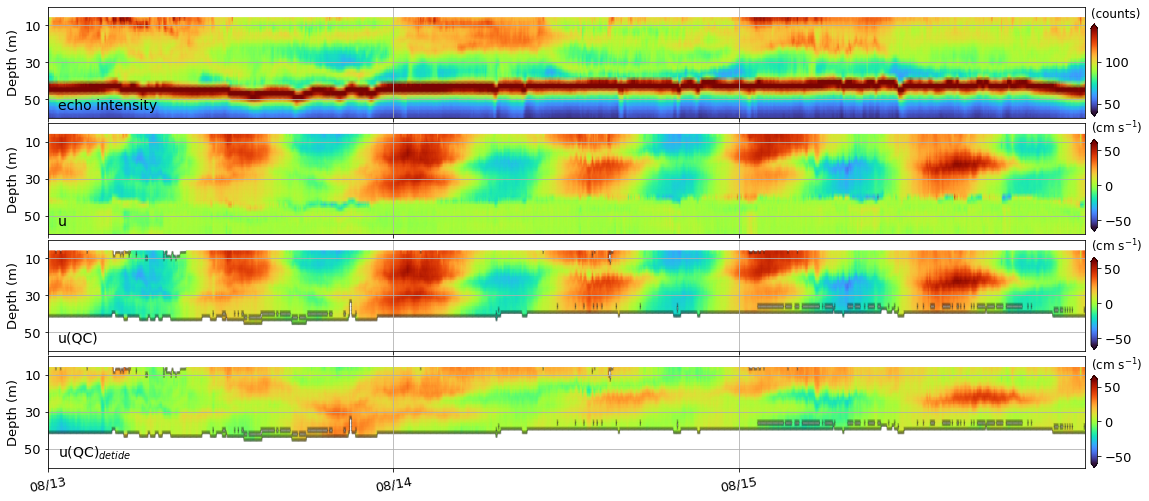

In [50]:
### plot (1) 1 beam of echo intensity (2) original u (3) QC u (4) detide QC u
tlim_plot = [datetime.datetime(int(year),8,13), datetime.datetime(int(year),8,16)]
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
it = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD< tlim_plot[1]) )[0]
vars_str = ['echo_intensity','uCur_SD','uCur_SD','uCur_SD_detide']
vars_str_title = ['echo intensity','u','u(QC)','u(QC)$_{detide}$']
vars_units = ['(counts)','(cm s$^{-1}$)','(cm s$^{-1}$)','(cm s$^{-1}$)']
iplot_QC = [False,False,True,True]
vars_lim = [[cri_min_echo,cri_max_echo],[-60,60],[-60,60],[-60,60]]
y0_cb = [0.71,0.51,0.305,0.1]
ylabels = ['Depth (m)']*nrow
nrow = len(vars_str)
cmap = 'turbo'
### plot
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 8)
plt.rcParams.update({'font.size': 13})
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    if i == 0:
        y = eval( vars_str[i]+'[:,0,:]' ).copy()
    else:
        y = eval( vars_str[i] ).copy()
    if iplot_QC[i] is True:
        y[~iOK_QC] = np.nan
    cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, y.transpose(),shading='gouraud',edgecolors='none',\
                        cmap=cmap,vmin=vars_lim[i][0],vmax=vars_lim[i][1])
    ### figure setting
    plt.xticks(tticks,rotation=10)
    if i == nrow-1:
        plt.gca().set_xticklabels(tticks_label)
    else:
        plt.gca().set_xticklabels('')
    plt.xlim(tlim_plot)
    plt.ylim([0,60])
    plt.yticks(np.arange(10,70,20))
    plt.gca().invert_yaxis()
    plt.grid()
    plt.ylabel(ylabels[i])
    plt.gca().text(0.01,0.05,vars_str_title[i],ha='left',va='bottom',transform=plt.gca().transAxes,fontsize=14)
    plt.gca().set_facecolor('white')
    ### add colorbar
    cbar_ax = fig.add_axes([.905,y0_cb[i],.005,.16])
    axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
    cbar_ax.set_title(vars_units[i],y=1.05,loc='left',fontsize=12)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
### save to figure
plt.savefig('time-depth_echo_uv_uv(QC)_detide_SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_gouraud.pdf',dpi=400,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

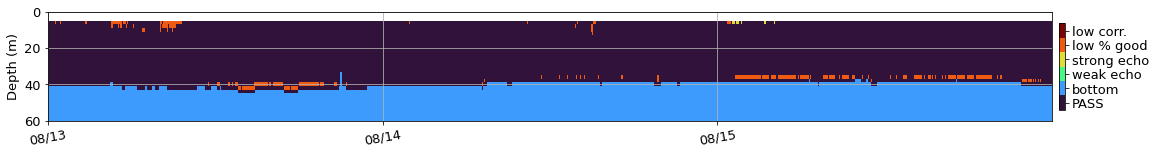

In [47]:
### plot data flag
str_flags = ['PASS','bottom','weak echo','strong echo','low % good','low corr.']
###
plt.clf()
fig, ax = plt.subplots(nrows=1)
plt.gcf().set_size_inches(18, 2)
plt.rcParams.update({'font.size': 13})
cmap_flag = plt.get_cmap('turbo', len(str_flags))
cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, iflag.transpose(), cmap=cmap_flag,\
                    vmin=-0.5,vmax=5.5)
plt.xlim(tlim_plot)
plt.xticks(tticks,rotation=10)
plt.gca().set_xticklabels(tticks_label)
plt.ylim([0,60])
plt.gca().invert_yaxis()
plt.grid()
plt.ylabel('Depth (m)')
### add colorbar
cbar_ax = fig.add_axes([.905,0.2,.005,0.6])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,ticks=np.arange(0,len(str_flags)))
cbar_ax.set_yticks(np.arange(0,len(str_flags)))
cbar_ax.set_yticklabels(str_flags)
### save figure
plt.savefig('time-depth_data-flags_SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')